# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнил: Воробьев Глеб
###### Группа: 307
###### Датасет (ссылка): [Фондовый рынок](https://www.kaggle.com/datasets/prince7489/stock-market-dataset)

---

# Задание:

0. Выбрать модель для обучения (Desicion tree, Random forest, SVM, KNN, Boosting)
1. Показать какие гиперпараметры есть у выбранной модели (В виде таблички).
2. Выбрать датасет для обучения и взависимости от модели подготовить данные
3. Подобрать гиперпараметры для модели и сравнить лучшие подборы, для (Grid Search, RandomSearch, Optuna)
4. На самом лучшем обучении (Grid Search, RandomSearch, Optuna) сделать калькулятор, который показывает `локальную интерпретацию` с помощью [LIME](https://habr.com/ru/companies/otus/articles/779430/) и `глобальную интерпретацию` с помощью [SHAP](https://habr.com/ru/companies/ods/articles/599573/).

    [Доп статья](https://habr.com/ru/companies/wunderfund/articles/739744/)

## Загрузка датасета

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv("random_stock_market_dataset.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,2024-01-01,296.45,307.31,293.96,303.72,93133
1,2024-01-02,190.11,193.10,187.21,191.40,64993
2,2024-01-03,197.41,208.64,193.37,205.89,70326
3,2024-01-04,253.13,262.67,248.67,258.95,17358
4,2024-01-05,241.35,253.09,238.99,252.20,20847


## EDA исходных признаков

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    60 non-null     object 
 1   Open    60 non-null     float64
 2   High    60 non-null     float64
 3   Low     60 non-null     float64
 4   Close   60 non-null     float64
 5   Volume  60 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 2.9+ KB


In [ ]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

stock_data = df.set_index('Date')[['Close']].copy()

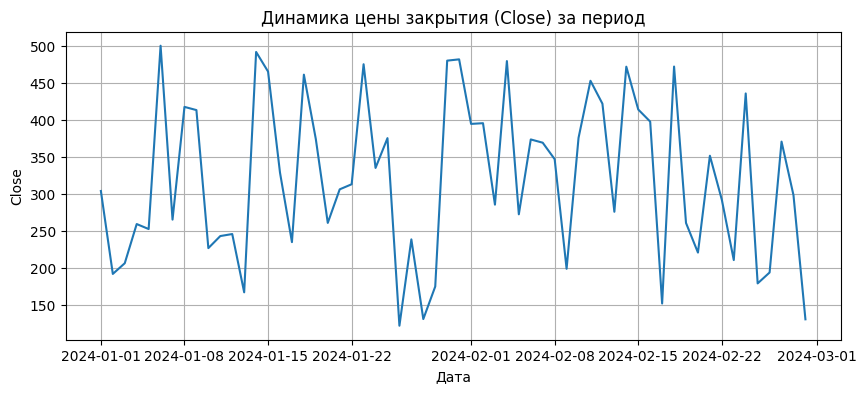

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(stock_data.index, stock_data['Close'])
plt.title("Динамика цены закрытия (Close) за период")
plt.xlabel("Дата")
plt.ylabel("Close")
plt.grid(True)
plt.show()

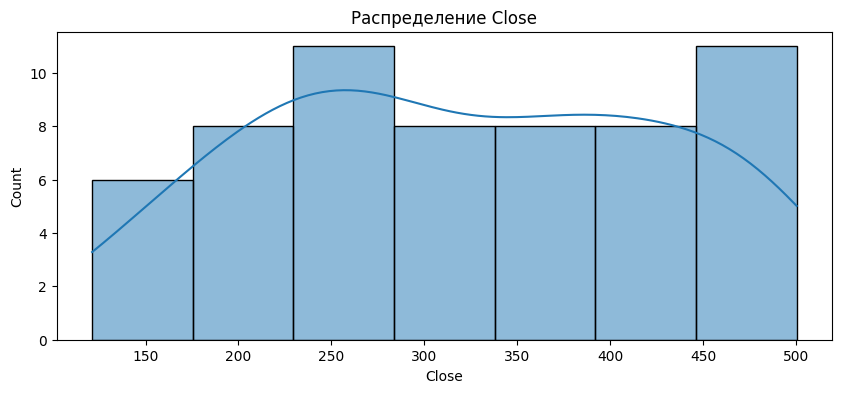

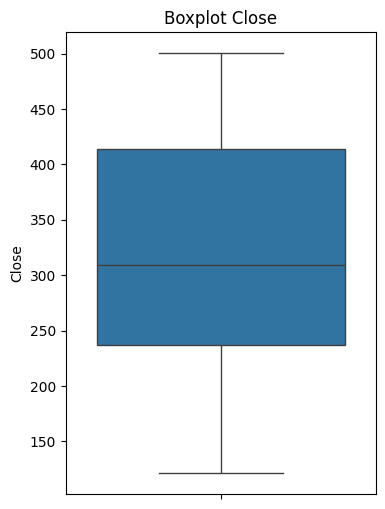

In [ ]:
df[['Open', 'High', 'Low', 'Close', 'Volume']].describe().T

plt.figure(figsize=(10, 4))
sns.histplot(df['Close'], kde=True)
plt.title("Распределение Close")
plt.show()

plt.figure(figsize=(4, 6))
sns.boxplot(y=df['Close'])
plt.title("Boxplot Close")
plt.show()


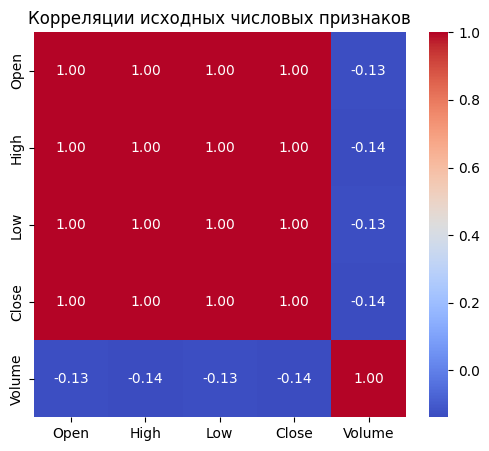

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляции исходных числовых признаков")
plt.show()

<Figure size 800x300 with 0 Axes>

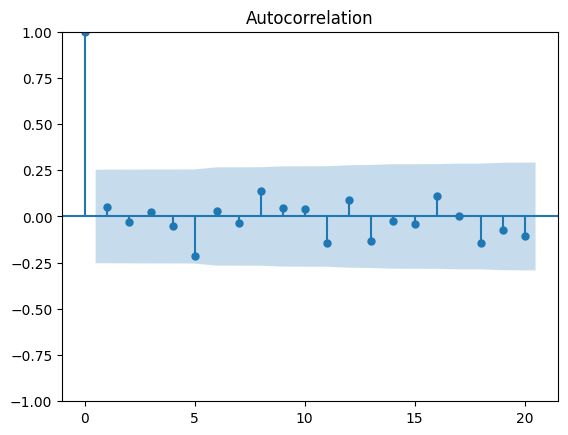

<Figure size 800x300 with 0 Axes>

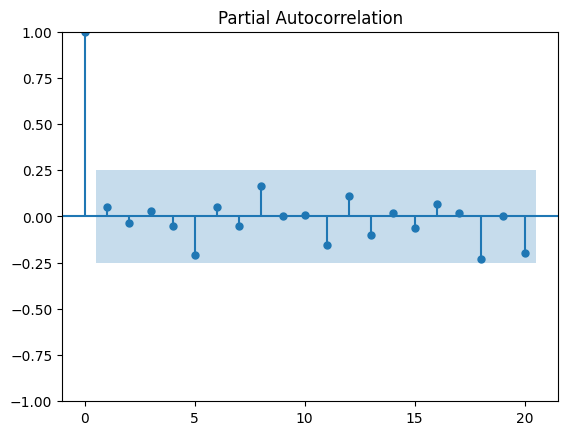

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

close_series = stock_data['Close'].dropna()

plt.figure(figsize=(8, 3))
plot_acf(close_series, lags=20)
plt.show()

plt.figure(figsize=(8, 3))
plot_pacf(close_series, lags=20)
plt.show()

## Feature engeneering

In [ ]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day

    df['ret1'] = df['Close'].pct_change()

    df['ma5'] = df['Close'].rolling(window=5).mean()

    df['ma5_dist'] = (df['Close'] - df['ma5']) / df['ma5']

    df['vol5'] = df['ret1'].rolling(window=5).std()

    return df

In [ ]:
def add_lags(df, n_lags=6):
    target = 'Close'
    for i in range(1, n_lags + 1):
        df[f'lag{i}'] = df[target].shift(i)

    return df

In [ ]:
df_fe = stock_data.copy()
df_fe = create_features(df_fe)
df_fe = add_lags(df_fe, n_lags=2)
df_fe = df_fe.dropna()

print("Размер df_fe:", df_fe.shape)
df_fe.head()

Размер df_fe: (55, 9)


,Close,dayofweek,dayofmonth,ret1,ma5,ma5_dist,vol5,lag1,lag2
Date,,,,,,,,,
2024-01-06,500.42,5,6,0.984219,281.772,0.775975,0.502083,252.20,258.95
2024-01-07,264.94,6,7,-0.470565,296.480,-0.106382,0.531068,500.42,252.20
2024-01-08,417.60,0,8,0.576206,338.822,0.232506,0.556765,264.94,500.42
2024-01-09,413.27,1,9,-0.010369,369.686,0.117895,0.570302,417.60,264.94
2024-01-10,226.35,2,10,-0.452295,364.516,-0.379040,0.641898,413.27,417.60


## EDA по новым признакам

In [ ]:
df_fe.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,55.0,327.501818,110.702201,121.270000,240.430000,334.930000,415.820000,500.420000
dayofweek,55.0,2.981818,2.032066,0.000000,1.000000,3.000000,5.000000,6.000000
dayofmonth,55.0,16.654545,8.233217,1.000000,10.000000,17.000000,23.500000,31.000000
ret1,55.0,0.133106,0.637600,-0.676863,-0.294723,-0.039513,0.446028,2.120325
ma5,55.0,327.649164,47.711501,207.878000,298.437000,332.688000,361.035000,407.496000
ma5_dist,55.0,0.000930,0.342225,-0.625631,-0.230687,-0.008813,0.179301,1.098277
vol5,55.0,0.630605,0.242557,0.231957,0.454900,0.554435,0.816412,1.119440
lag1,55.0,329.724545,107.852839,121.270000,244.055000,334.930000,415.820000,500.420000
lag2,55.0,329.014364,108.193600,121.270000,244.055000,334.930000,415.820000,500.420000


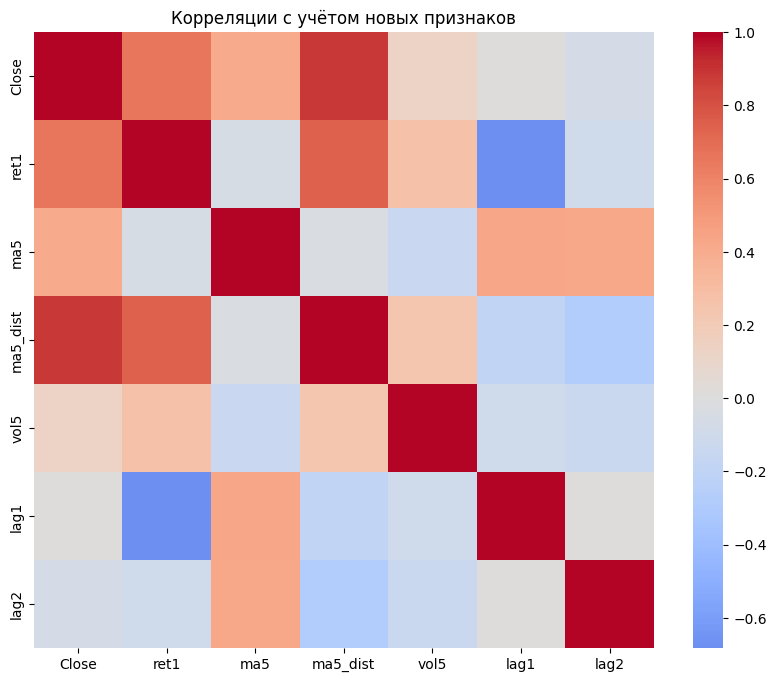

In [ ]:
numeric_cols = df_fe.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(10, 8))
corr_matrix = df_fe[numeric_cols].corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Корреляции с учётом новых признаков")
plt.show()

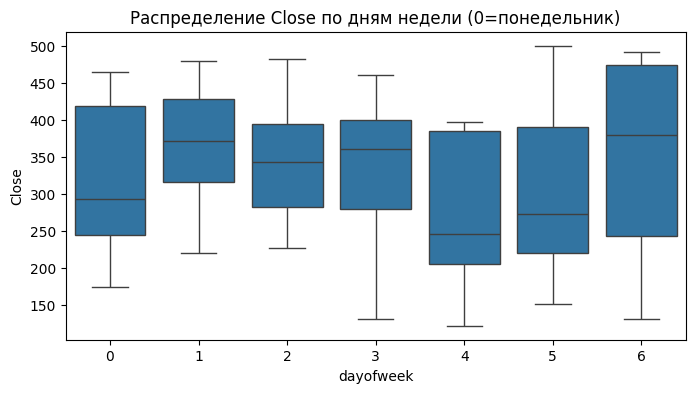

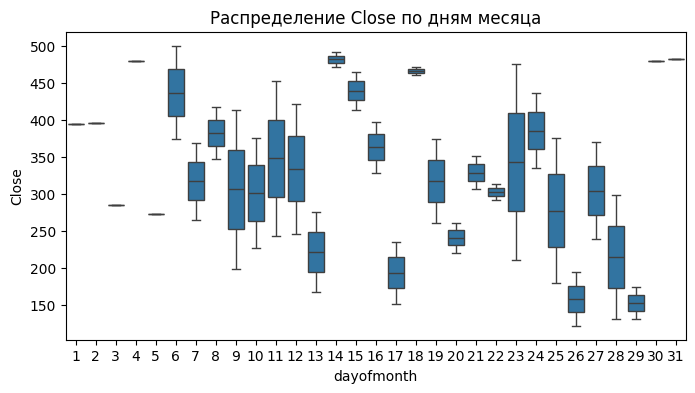

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='dayofweek', y='Close', data=df_fe)
plt.title("Распределение Close по дням недели (0=понедельник)")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='dayofmonth', y='Close', data=df_fe)
plt.title("Распределение Close по дням месяца")
plt.show()

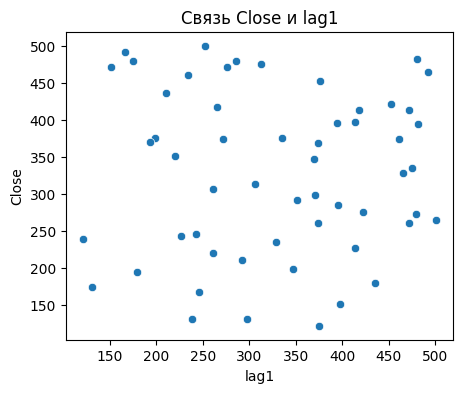

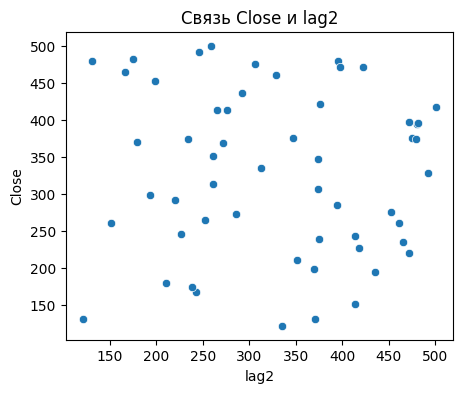

In [ ]:
lags_to_plot = ['lag1', 'lag2']

for lag in lags_to_plot:
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=df_fe[lag], y=df_fe['Close'])
    plt.xlabel(lag)
    plt.ylabel('Close')
    plt.title(f"Связь Close и {lag}")
    plt.show()

## Обучение

In [ ]:
features = ['ret1', 'ma5_dist', 'vol5', 'lag1', 'lag2', 'dayofweek', 'dayofmonth']


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

df_model = df_fe.copy()

df_model['target'] = df_model['Close'].shift(-1)

cols_for_model = features + ['target']
df_model = df_model[cols_for_model].dropna()

print("Размер df_model:", df_model.shape)
display(df_model.head())

X = df_model[features]
y = df_model['target']

split_idx = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Размер df_model: (54, 8)


,ret1,ma5_dist,vol5,lag1,lag2,dayofweek,dayofmonth,target
Date,,,,,,,,
2024-01-06,0.984219,0.775975,0.502083,252.20,258.95,5,6,264.94
2024-01-07,-0.470565,-0.106382,0.531068,500.42,252.20,6,7,417.60
2024-01-08,0.576206,0.232506,0.556765,264.94,500.42,0,8,413.27
2024-01-09,-0.010369,0.117895,0.570302,417.60,264.94,1,9,226.35
2024-01-10,-0.452295,-0.379040,0.641898,413.27,417.60,2,10,242.69


Train size: (43, 7) Test size: (11, 7)


In [ ]:
!pip install optuna

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
import optuna

In [ ]:
def regression_metrics(y_true, y_pred, name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"{name}  RMSE={rmse:.3f}, MAE={mae:.3f}, MAPE={mape:.2f}%")
    return rmse, mae, mape

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.03, 0.05, 0.1],
    'subsample': [0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
y_pred_grid = best_grid.predict(X_test)
rmse_grid, mae_grid, mape_grid = regression_metrics(y_test, y_pred_grid, name="GridSearch")
print("Grid best params:", grid_search.best_params_)


GridSearch  RMSE=140.218, MAE=130.226, MAPE=59.59%
Grid best params: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 400),
    'max_depth': randint(2, 6),
    'learning_rate': uniform(0.01, 0.15),
    'subsample': uniform(0.7, 0.3),
}

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

random_search.fit(X_train, y_train)

best_random = random_search.best_estimator_
y_pred_random = best_random.predict(X_test)
rmse_rand, mae_rand, mape_rand = regression_metrics(y_test, y_pred_random, name="RandomSearch")
print("Random best params:", random_search.best_params_)


RandomSearch  RMSE=134.987, MAE=124.907, MAPE=58.58%
Random best params: {'learning_rate': np.float64(0.013459363756212364), 'max_depth': 4, 'n_estimators': 108, 'subsample': np.float64(0.8199582915145766)}


In [ ]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'random_state': 42,
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
    return rmse

study = optuna.create_study(direction='minimize')
six = study.optimize(objective, n_trials=30, show_progress_bar=False)

print("Optuna best value (RMSE):", study.best_value)
print("Optuna best params:", study.best_trial.params)

best_optuna = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    **study.best_trial.params
)
best_optuna.fit(X_train, y_train)

y_pred_opt = best_optuna.predict(X_test)
rmse_opt, mae_opt, mape_opt = regression_metrics(y_test, y_pred_opt, name="Optuna")

[I 2025-11-21 21:35:02,030] A new study created in memory with name: no-name-0b7c90a2-427d-427e-b3a7-7bac03cbbdd2
[I 2025-11-21 21:35:02,555] Trial 0 finished with value: 154.37272588681802 and parameters: {'n_estimators': 344, 'max_depth': 3, 'learning_rate': 0.1080198653226883, 'subsample': 0.751987330710292, 'colsample_bytree': 0.781724454120623}. Best is trial 0 with value: 154.37272588681802.
[I 2025-11-21 21:35:03,198] Trial 1 finished with value: 157.7423939091875 and parameters: {'n_estimators': 384, 'max_depth': 4, 'learning_rate': 0.14195532762356883, 'subsample': 0.8182934840682692, 'colsample_bytree': 0.7565380658331885}. Best is trial 0 with value: 154.37272588681802.
[I 2025-11-21 21:35:04,121] Trial 2 finished with value: 146.80082390840096 and parameters: {'n_estimators': 323, 'max_depth': 4, 'learning_rate': 0.07121307879432999, 'subsample': 0.857530548033188, 'colsample_bytree': 0.9906742926826395}. Best is trial 2 with value: 146.80082390840096.
[I 2025-11-21 21:35:0

Optuna best value (RMSE): 120.57957032262577
Optuna best params: {'n_estimators': 53, 'max_depth': 5, 'learning_rate': 0.01170967098590195, 'subsample': 0.7833799558870658, 'colsample_bytree': 0.7306157653677331}
Optuna  RMSE=120.580, MAE=108.786, MAPE=52.42%


In [ ]:
results = pd.DataFrame({
    'method': ['GridSearch', 'RandomSearch', 'Optuna'],
    'RMSE': [rmse_grid, rmse_rand, rmse_opt],
    'MAE':  [mae_grid,  mae_rand,  mae_opt],
    'MAPE': [mape_grid, mape_rand, mape_opt],
})
results


,method,RMSE,MAE,MAPE
0,GridSearch,140.217923,130.225697,59.594750
1,RandomSearch,134.987226,124.907141,58.577967
2,Optuna,120.579570,108.785819,52.420229


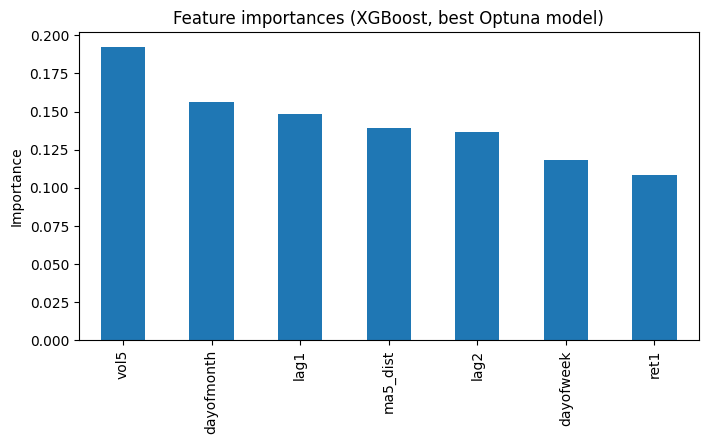

In [ ]:
import matplotlib.pyplot as plt

importances = best_optuna.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
feat_imp.plot(kind='bar')
plt.title("Feature importances (XGBoost, best Optuna model)")
plt.ylabel("Importance")
plt.show()


In [ ]:
display(results)

best_method = results.loc[results['RMSE'].idxmin(), 'method']
print("Лучший метод подбора гиперпараметров:", best_method)

if best_method == 'GridSearch':
    best_model = best_grid
elif best_method == 'RandomSearch':
    best_model = best_random
else:
    best_model = best_optuna

print(best_model)

,method,RMSE,MAE,MAPE
0,GridSearch,140.217923,130.225697,59.594750
1,RandomSearch,134.987226,124.907141,58.577967
2,Optuna,120.579570,108.785819,52.420229


Лучший метод подбора гиперпараметров: Optuna
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7306157653677331, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01170967098590195,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=53, n_jobs=None,
             num_parallel_tree=None, ...)


In [ ]:
!pip install shap

In [ ]:
import shap
shap.initjs()

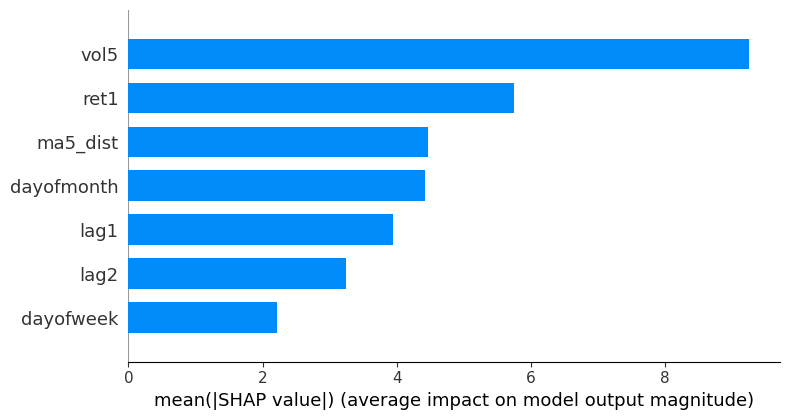

In [ ]:
explainer = shap.TreeExplainer(best_model)

shap_values_train = explainer.shap_values(X_train)

shap.summary_plot(shap_values_train, X_train, plot_type="bar")

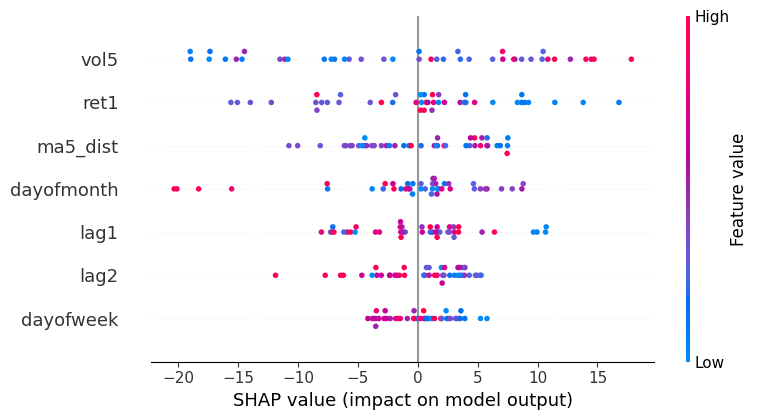

In [ ]:
shap.summary_plot(shap_values_train, X_train)

In [ ]:
!pip install lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

In [ ]:
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['target'],
    mode='regression'
)


In [ ]:
def explain_instance(idx):

    x = X_test.iloc[idx]
    print("Признаки объекта:")
    display(x.to_frame().T)

    pred = best_model.predict(x.values.reshape(1, -1))[0]
    print(f"Прогноз модели (target): {pred:.4f}\n")

    print("LIME — вклад признаков:")
    lime_exp = lime_explainer.explain_instance(
        data_row=x.values,
        predict_fn=best_model.predict,
        num_features=len(X_test.columns)
    )

    display(pd.DataFrame(lime_exp.as_list(), columns=['feature', 'contribution']))

    print("\nSHAP — force plot:")
    shap_values_single = explainer.shap_values(x.values.reshape(1, -1))
    shap.force_plot(
        explainer.expected_value,
        shap_values_single[0],
        x,
        matplotlib=True
    )

Признаки объекта:


,ret1,ma5_dist,vol5,lag1,lag2,dayofweek,dayofmonth
2024-02-18,2.120325,0.237922,1.068041,151.34,397.68,6.0,18.0


Прогноз модели (target): 371.1134

LIME — вклад признаков:


,feature,contribution
0,vol5 > 0.65,13.963353
1,14.00 < dayofmonth <= 20.50,6.800019
2,lag1 <= 256.35,5.707452
3,ma5_dist > 0.18,4.233681
4,346.79 < lag2 <= 419.76,-1.236400
5,ret1 > 0.36,-0.772187
6,dayofweek > 5.00,0.155023



SHAP — force plot:


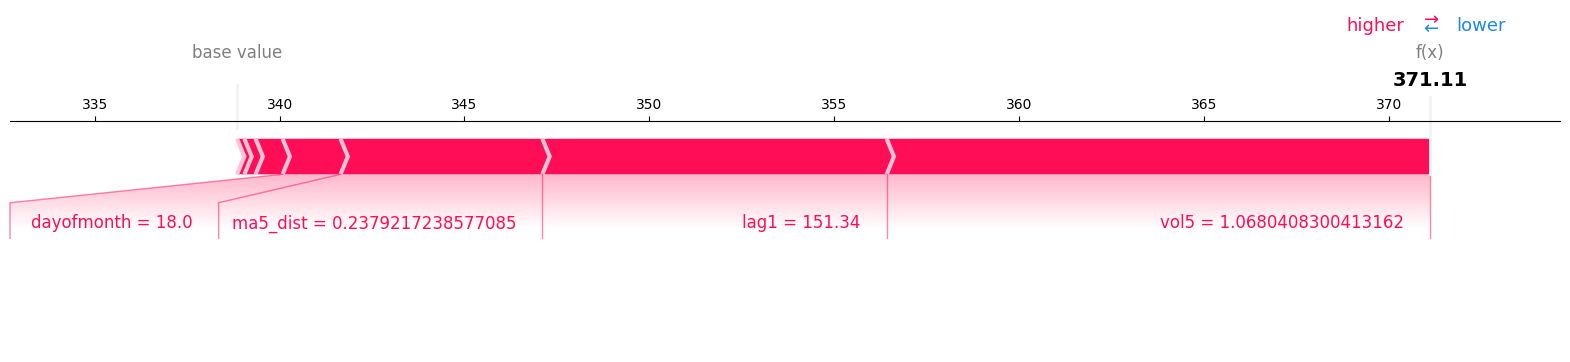

In [ ]:
explain_instance(0)

#

# Сроки

- до 17.11.25 оценка 5
- до 24.11.25 оценка 4

# Формат сдачи

1. Защита преподавателю
2. Презентация о проделанной работе (10-15 слайдов)
3. Файл `FIO_lr3.ibynb`